# Predicting Stock Market Valuation with The Fed Model
By: Cordell L. Tanny, CFA, FRM, FDP

2024-07-08

Property of Digital Hub Insights LLC.

This notebook accompanies the article on Medium. Please use thew article as a guide and to provide more information and context.



Note: The S&P 500 historical P/E information is provided via free download on macrotrends.net with the following link:

https://www.macrotrends.net/2577/sp-500-pe-ratio-price-to-earnings-chart

Thank you to macrotrends.net for making this information freely available!

The data file is sp500_historical_pe.csv, available in our github repo.
Please make sure to upload it into the correct location so that the code can locate it.




## Summary

**What You Need to Know:**

**Fed Model Basics:** Compares the S&P 500 earnings yield to the 10-year US Treasury bond yield to assess market attractiveness.

**Spread Interpretation:** A positive spread suggests equities are undervalued; a negative spread indicates bonds are more attractive.

**Source:** Popularized by Ed Yardeni, the model shows mixed reliability but remains a useful valuation tool.

**Why It Matters:**

**Investment Strategy:** Understanding the spread helps investors make informed decisions about asset allocation between stocks and bonds.

**Current Market Conditions:** The spread has turned negative for the first time in 16 years, signaling potential overvaluation in equities and attractiveness in bonds.

**Inflation's Role:** Granger causality test results indicate that past CPI inflation rates can predict the Fed Model differential, offering insights for market forecasting.


## Imports

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import pandas_datareader.data as web
from statsmodels.tsa.stattools import grangercausalitytests


sns.set_theme()

## Some needed functions
We will first define a couple of functions so that we can add recession bands to our graphs.

These functions were introduced in a previous article:
https://medium.com/ai-advances/create-python-financial-graphs-like-a-pro-add-recession-bands-6d17ca5f0978

In [2]:
# first let's remember the recession bands that I presented
# in a previous article; always makes an econ graph better!
# https://medium.com/ai-advances/create-python-financial-graphs-like-a-pro-add-recession-bands-6d17ca5f0978

def fetch_recession_periods(start_date, end_date):
    """
    Fetches the start and end dates of US recessions within a given date range from the FRED database.

    This function retrieves recession indicators (USREC) from FRED and processes the data to find
    the precise start and end dates of each recession period. The start of a recession is marked
    by the last day of the month before the recession indicator turns to 1, and the end is marked
    by the last day of the month when the recession indicator is 1 before turning back to 0.

    Parameters:
    - start_date (str): The start date for fetching the recession data, formatted as 'YYYY-MM-DD'.
    - end_date (str): The end date for fetching the recession data, formatted as 'YYYY-MM-DD'.

    Returns:
    - dict: A nested dictionary where each key is a recession number and its value is another
            dictionary with 'start' and 'end' keys indicating the respective start and end dates
            of the recession, formatted as 'YYYY-MM-DD'.
    """

    # Fetch US recession data from FRED using the provided date range
    usrec = web.DataReader("USREC", "fred", start_date, end_date)

    # Initialize variables for tracking recessions and their dates
    recessions = {}
    recession_num = 0
    start = None

    # Iterate through the recession data to identify start and end dates
    for i in range(len(usrec)):
        if usrec.iloc[i, 0] == 1:  # Current month is marked as a recession month
            if start is None:  # This marks the beginning of a new recession
                start = usrec.index[i]  # Record the start date
                # Adjust to the last day of the start month
                start = datetime(start.year, start.month, calendar.monthrange(start.year, start.month)[1])
            # Keep updating the end date as long as the recession continues
            end = usrec.index[i]
            end = datetime(end.year, end.month, calendar.monthrange(end.year, end.month)[1])
        elif start is not None:  # Recession ends when a month is not marked as a recession month
            recession_num += 1
            # Store the start and end dates of the recession
            recessions[recession_num] = {'start': start.strftime('%Y-%m-%d'), 'end': end.strftime('%Y-%m-%d')}
            start = None  # Reset start for the next recession

    # Handle case where the data ends but a recession is ongoing
    if start is not None:
        recession_num += 1
        recessions[recession_num] = {'start': start.strftime('%Y-%m-%d'), 'end': end.strftime('%Y-%m-%d')}

    # Special case handling for when the data starts during a recession
    if usrec.iloc[0, 0] == 1:
        # Adjust the start date to the last day of the month before the data start date
        first_start = usrec.index[0] - pd.offsets.MonthBegin(1)
        first_start = datetime(first_start.year, first_start.month, calendar.monthrange(first_start.year, first_start.month)[1])
        recessions[1]['start'] = first_start.strftime('%Y-%m-%d')

    return recessions


def add_recession_bands(ax, recessions, start_date, end_date):
    """
    Adds shaded areas to the plot for each recession period that overlaps with the given date range.

    Parameters:
    - ax: The Matplotlib Axes object on which to add the recession bands.
    - recessions (dict): A dictionary containing the start and end dates of recessions.
    - start_date (str): The start date for the plot's data range in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the plot's data range in 'YYYY-MM-DD' format.
    """
    plot_start_date = pd.to_datetime(start_date)
    plot_end_date = pd.to_datetime(end_date)

    # Add vertical shaded areas (vspan) for each recession period
    for rec_num, rec_dates in recessions.items():
        rec_start_date = pd.to_datetime(rec_dates['start'])
        rec_end_date = pd.to_datetime(rec_dates['end'])

        # Check if the recession period overlaps with the plot's data range
        if (rec_start_date <= plot_end_date) and (rec_end_date >= plot_start_date):
            ax.axvspan(rec_start_date, rec_end_date, color="red", alpha=0.2)

## Import the data
Make sure the file is in the correct folder or imported into Colab.

In [4]:
# Initialization
start_date = '1990-01-01'
end_date = '2024-05-31'  # last date of the data in the pe file

# load the pe data
df_pe = pd.read_csv('sp500_historical_pe.csv', index_col=0, header=0, parse_dates=True)

# Examine the data
df_pe.head()

,S&P 500 P/E (TTM)
date,
1927-12-31,15.9099
1928-01-31,14.8898
1928-02-29,14.6271
1928-03-31,16.3390
1928-04-30,15.8000


## Create the Fed Model
1. Create the Fed Model by taking the inverse of the historical PE values.

2. Retreive the 10-year treasury yields from FRED.

3. Merge into df_merged.

In [12]:
# create the earnings yield by taking the inverse of the pe ratio
df_ey = (1 / df_pe['S&P 500 P/E (TTM)'].to_frame(name='S&P 500 Earnings Yield')).mul(100).round(2)
# load the 10-year yield, resample to month end
df_10yr = pdr.get_data_fred(['DGS10'], start=start_date, end=end_date)
df_10yr = df_10yr.resample('M').last()

# merge the 2 dataframes and drop rows before the start date
df_merged = pd.concat([df_ey, df_10yr], axis=1).dropna()

# create the fed model
df_merged['fed_model'] = df_merged['S&P 500 Earnings Yield'] - df_merged['DGS10']

# Examine the dataframe
df_merged.head()

,S&P 500 Earnings Yield,DGS10,fed_model
1990-01-31,6.59,8.43,-1.84
1990-02-28,6.53,8.51,-1.98
1990-03-31,6.37,8.65,-2.28
1990-04-30,6.43,9.04,-2.61
1990-05-31,5.89,8.60,-2.71


## Plotting the model

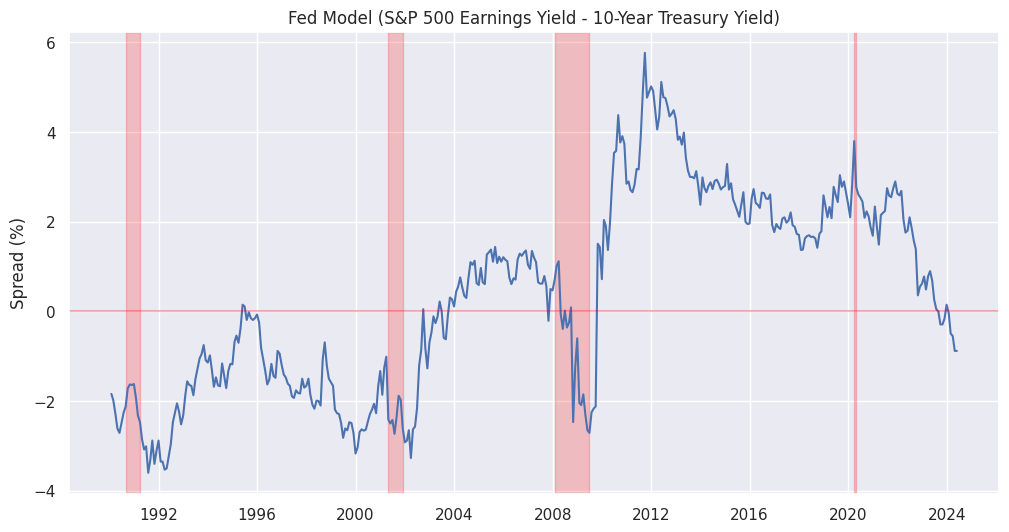

In [9]:
# %% plot the data
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df_merged['fed_model'], ax=ax)
ax.set_title('Fed Model (S&P 500 Earnings Yield - 10-Year Treasury Yield)')
ax.set_ylabel('Spread (%)')
# add horizontal line at 0, color red at alpha = 0.3
ax.axhline(0, color='red', alpha=0.3)
# retrieve previous recessions to create recession bands
# start it before the data to make sure we capture the beginning of a recession
recessions = fetch_recession_periods('1980-01-01', end_date)
add_recession_bands(ax, recessions, start_date, end_date)
plt.show()

## How is the model influenced by inflation?

In [13]:
# load cpi data and convert to year over year at month end
df_cpi = pdr.get_data_fred(['CPIAUCSL'], '1989-01-01', end_date).pct_change(12).mul(100).dropna()
df_cpi.columns = ['US CPI Y/Y % Change']
# convert the index of df_cpi to monthend (by default it comes in as the first of the month and not the last)
df_cpi.index = df_cpi.index + pd.offsets.MonthEnd(0)

# Add the CPI Y/Y to df_merged
df_merged = pd.concat([df_merged, df_cpi], axis=1)

# inspect the dataframe
df_merged.head()

,S&P 500 Earnings Yield,DGS10,fed_model,US CPI Y/Y % Change
1990-01-31,6.59,8.43,-1.84,5.198020
1990-02-28,6.53,8.51,-1.98,5.263158
1990-03-31,6.37,8.65,-2.28,5.237316
1990-04-30,6.43,9.04,-2.61,4.711617
1990-05-31,5.89,8.60,-2.71,4.365400


## Plot the Fed Model vs. CPI YoY changes

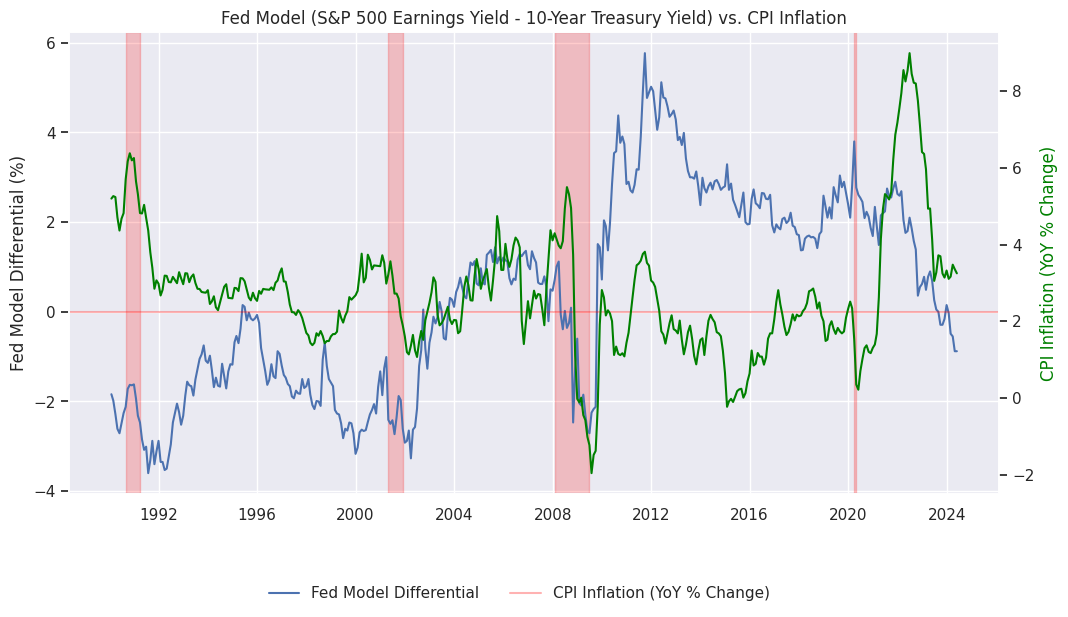

In [18]:
# Create a figure and a primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the Fed Model differential on the left y-axis
sns.lineplot(data=df_merged['fed_model'], ax=ax1)
ax1.set_title('Fed Model (S&P 500 Earnings Yield - 10-Year Treasury Yield) vs. CPI Inflation')
ax1.set_ylabel('Fed Model Differential (%)')
ax1.axhline(0, color='red', alpha=0.3)

# Add recession bands
fetch_recession_periods('1980-01-01', end_date)  # Adjust start_date and end_date as needed
add_recession_bands(ax1, recessions, start_date, end_date)

# Create a secondary y-axis for CPI Inflation
ax2 = ax1.twinx()
sns.lineplot(data=df_merged['US CPI Y/Y % Change'], ax=ax2, color='green')
ax2.set_ylabel('CPI Inflation (YoY % Change)', color='green')

# Combine legends from both y-axes
lines1, labels1 = ax1.get_lines(), ['Fed Model Differential']
lines2, labels2 = ax2.get_lines(), ['CPI Inflation (YoY % Change)']

# Create a single combined legend below the plot
fig.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2,
           frameon=False)

# Ensure grid lines are only on the left y-axis
ax1.yaxis.grid(True)
ax2.yaxis.grid(False)

plt.show()

## Granger Causality Test

In [21]:
# Granger Causality Test
def perform_granger_causality_test(data, max_lag):
    """
    Perform the Granger causality test with a clean output.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the two time series.
    - max_lag (int): The maximum number of lags to test.

    Returns:
    - result (dict): Dictionary containing test statistics and significant lags.
    """
    test_result = grangercausalitytests(data, max_lag, verbose=False)

    clean_output = []
    for lag in range(1, max_lag + 1):
        ssr_ftest = test_result[lag][0]['ssr_ftest']
        f_statistic, p_value, df_denom, df_num = ssr_ftest

        result_entry = {
            'Lag': lag,
            'F-Statistic': f_statistic,
            'p-Value': p_value,
            'Significant': p_value < 0.05  # Indicate significance at the 0.05 level
        }

        clean_output.append(result_entry)

    result_df = pd.DataFrame(clean_output)
    significant_lags = result_df[result_df['Significant']]['Lag'].tolist()

    print("Granger Causality Test Results:")
    print(result_df)
    if significant_lags:
        print(f"\nSignificant lags (p < 0.05): {significant_lags}")
    else:
        print("\nNo significant lags found.")

    return result_df


max_lag = 4  # Define the maximum number of lags to test
df_test = df_merged[['fed_model', 'US CPI Y/Y % Change']]  # Adjust to your actual DataFrame
perform_granger_causality_test(df_test, max_lag)

Granger Causality Test Results:
   Lag  F-Statistic   p-Value  Significant
0    1     2.606970  0.107166        False
1    2     2.578026  0.077166        False
2    3     6.419102  0.000296         True
3    4     3.953651  0.003689         True

Significant lags (p < 0.05): [3, 4]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,Lag,F-Statistic,p-Value,Significant
0,1,2.606970,0.107166,False
1,2,2.578026,0.077166,False
2,3,6.419102,0.000296,True
3,4,3.953651,0.003689,True


## Scatter plot

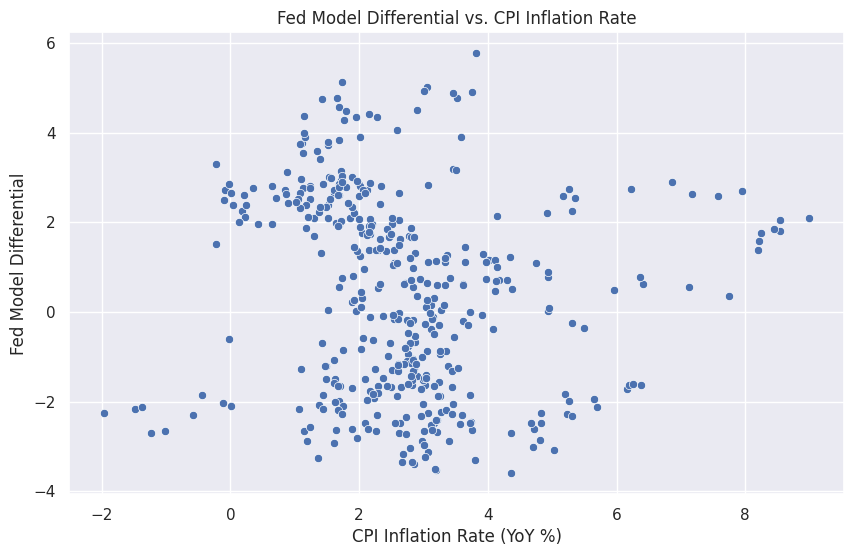

Correlation between Fed Model Differential and CPI Inflation Rate: -0.11


In [23]:
# Scatter plot of Fed Model differential vs. CPI inflation rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='US CPI Y/Y % Change', y='fed_model', data=df_merged)
plt.title('Fed Model Differential vs. CPI Inflation Rate')
plt.xlabel('CPI Inflation Rate (YoY %)')
plt.ylabel('Fed Model Differential')
plt.show()


# Calculate correlation
correlation = df_merged['fed_model'].corr(df_merged['US CPI Y/Y % Change'])
print(f'Correlation between Fed Model Differential and CPI Inflation Rate: {correlation:.2f}')